# Subspace Creation

The next step in the detex workflow is to create a SubSpace object from a given cluster. Before we get too far into this let's look at a new data set. 

## The data set

The data we will be working with are from a waste water injection site in Ohio. An excellent article on this site was recently published. Its reference is:


Friberg, Paul A., Glenda M. Besana‐Ostman, and Ilya Dricker. "Characterization of an earthquake sequence triggered by hydraulic fracturing in Harrison County, Ohio." Seismological Research Letters (2014).


The station key, template key,  look like this:

In [1]:
import detex
%matplotlib inline
# display station key
stakey = detex.util.readKey("StationKey.csv", "station")
stakey


,NETWORK,STATION,STARTTIME,ENDTIME,LAT,LON,ELEVATION,CHANNELS
0,TA,O53A,2013-09-06T00-00-00,2013-09-16T00-00-00,40.2493,-81.2129,320,BHZ-BHN-BHE
1,TA,O52A,2013-09-06T00-00-00,2013-09-16T00-00-00,40.1158,-81.8361,331,BHZ-BHN-BHE


In [2]:
temkey = detex.util.readKey("TemplateKey.csv", "template")
temkey

,TIME,NAME,LAT,LON,MAG,DEPTH,STMP
0,2013-10-02T00-01-28.31,2013-10-02T00-01-28.31,40.218167,-81.23250,1.6,1.01,2013-10-02T00:01:28.310000Z
1,2013-10-02T01-43-30.31,2013-10-02T01-43-30.31,40.241500,-81.22433,1.6,4.36,2013-10-02T01:43:30.310000Z
2,2013-10-02T01-52-48.36,2013-10-02T01-52-48.36,40.234333,-81.20250,1.6,3.64,2013-10-02T01:52:48.360000Z
3,2013-10-02T03-03-14.81,2013-10-02T03-03-14.81,40.246500,-81.23817,1.8,4.01,2013-10-02T03:03:14.810000Z
4,2013-10-02T03-19-11.57,2013-10-02T03-19-11.57,40.233660,-81.23250,2.0,2.22,2013-10-02T03:19:11.570000Z
5,2013-10-02T10:06:57.34,2013-10-02T10:06:57.34,40.244500,-81.23200,2.0,4.14,2013-10-02T10:06:57.340000Z
6,2013-10-03T14-40-40.91,2013-10-03T14-40-40.91,40.211170,-81.20617,1.7,2.10,2013-10-03T14:40:40.910000Z
7,2013-10-05T00-16-15.76,2013-10-05T00-16-15.76,40.241330,-81.25430,2.2,4.55,2013-10-05T00:16:15.760000Z
8,2013-10-08T06-25-47.96,2013-10-08T06-25-47.96,40.223660,-81.22167,1.7,2.44,2013-10-08T06:25:47.960000Z
9,2013-10-19T06-48-40.01,2013-10-19T06-48-40.01,40.226600,-81.23733,1.9,2.07,2013-10-19T06:48:40.010000Z


Additionally, we know when a nearby well began injection and ceased injection

In [3]:
import obspy
start_inject = obspy.UTCDateTime('2013-09-07T01:45:00').timestamp
stop_inject = obspy.UTCDateTime('2013-10-06T13:18:00').timestamp


## Setup
Now we need to get the data and perform the waveform clustering. This will probably take about 20 minutes depending on your internet connection.

In [4]:
detex.getdata.makeDataDirectories()

Getting template waveforms
Getting continuous data
finished makeDataDirectories call


Cannot remove response without a valid inventoryArg, setting removeResponse to False
Starting IO operations and data checks
performing cluster analysis on TA.O52A
performing cluster analysis on TA.O53A
ccReq for station TA.O52A updated to ccReq=0.500
ccReq for station TA.O53A updated to ccReq=0.500
writing ClusterStream instance as clust.pkl


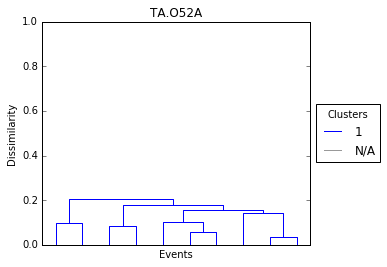

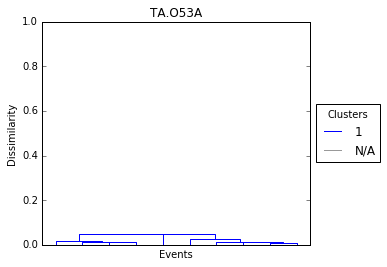

In [5]:
import detex
%matplotlib inline
cl = detex.createCluster()
cl.dendro()

The 10 events we have selected are very similar, so I am going to leave them in one cluster. Let's see where they plot according to the ANF catalog. 

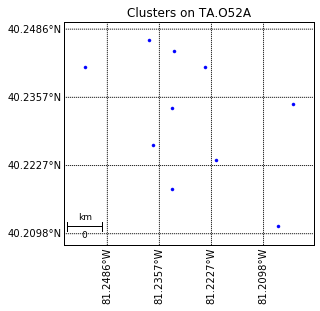

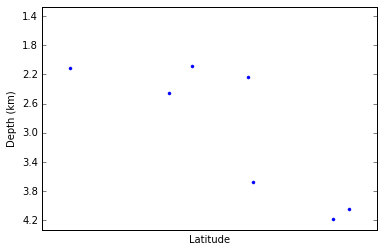

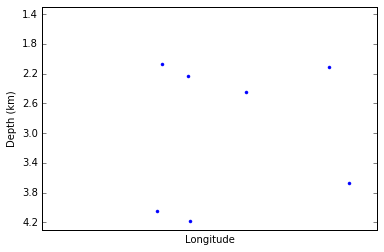

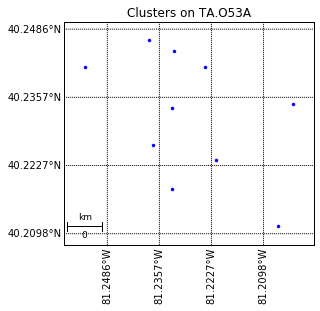

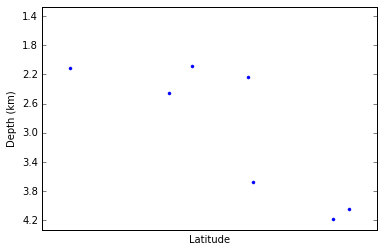

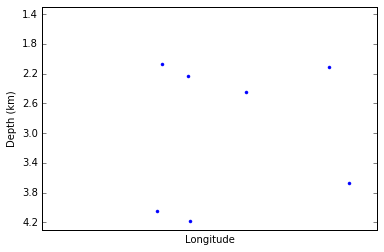

In [6]:
cl.plotEvents()

## Create subspace
Next we are ready to create the subspace object. The SubSpace class requires a ClusterStream instance for input. You can pass it directly to the SubSpace class via the "cl" keyword in the init method or detex will look for a pickeled instance with the default name of "clust.pkl" in the current working directly. Whenever you create a cluster object or update its correlation coeficient requirement it is pickeled (saved to disk) with the default name. In this case we will just use the default. 

In [8]:
ss = detex.createSubSpace() # we could also use ss = detex.construct.createSubSpace()

Cannot remove response without a valid inventoryArg, setting removeResponse to False
Starting Subspace Construction
Finished CreateSubSpace call


## Attach picks
Now we can attach the picks. These are contained in a csv that is name "PhasePicks.csv" by defualt. I created the csv by calling detex.util.pickPhases. The pickPhases function uses an altered version of streamPick (https://github.com/miili/StreamPick) which is a fantistic light-weight gui for making phase picks. 


In [9]:
ss.attachPickTimes()

## SVD and set thresholds
Next we need to call the SVD method of the SubSpace class. It will perform the singular value decomposition in order to create an otho-normal representation of the aligned waveforms. This is done primarily as a method of dimensonality reduction. The main method for determining how many dimensions a subspace needs to represent the events that went into it well is through an average percent energy capture requirement. If you are not sure what I am talking about take a look at figure 8 of Dave Haris' [subspace paper](https://e-reports-ext.llnl.gov/pdf/335299.pdf). 

After these steps are complete the SVD function will try to determine a threshold of detection that is significant. This is done by running the subspace detector over continuous data  